# IBM HR Analytics Employee Attrition & Performance

# Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore') # Ignore warning messages for readability

In [2]:
import pyspark
from pyspark.sql import SparkSession, Window, DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [3]:
df = pd.read_csv('employee_attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [5]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

# Data Preparation

In [7]:
categ = ['Attrition', 'BusinessTravel', 'Department', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime', 'EducationField']
df_categ = df[categ]

In [8]:
df_categ

,Attrition,BusinessTravel,Department,Gender,JobRole,MaritalStatus,Over18,OverTime,EducationField
0,Yes,Travel_Rarely,Sales,Female,Sales Executive,Single,Y,Yes,Life Sciences
1,No,Travel_Frequently,Research & Development,Male,Research Scientist,Married,Y,No,Life Sciences
2,Yes,Travel_Rarely,Research & Development,Male,Laboratory Technician,Single,Y,Yes,Other
3,No,Travel_Frequently,Research & Development,Female,Research Scientist,Married,Y,Yes,Life Sciences
4,No,Travel_Rarely,Research & Development,Male,Laboratory Technician,Married,Y,No,Medical
...,...,...,...,...,...,...,...,...,...
1465,No,Travel_Frequently,Research & Development,Male,Laboratory Technician,Married,Y,No,Medical
1466,No,Travel_Rarely,Research & Development,Male,Healthcare Representative,Married,Y,No,Medical
1467,No,Travel_Rarely,Research & Development,Male,Manufacturing Director,Married,Y,Yes,Life Sciences
1468,No,Travel_Frequently,Sales,Male,Sales Executive,Married,Y,No,Medical


In [9]:
#print unique cateogries in column 
for col in df_categ:
    print(df[col].unique())

['Yes' 'No']
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
['Sales' 'Research & Development' 'Human Resources']
['Female' 'Male']
['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
['Single' 'Married' 'Divorced']
['Y']
['Yes' 'No']
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']


In [10]:
for col in df_categ:
    print({col : df[col].unique()})

{'Attrition': array(['Yes', 'No'], dtype=object)}
{'BusinessTravel': array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)}
{'Department': array(['Sales', 'Research & Development', 'Human Resources'], dtype=object)}
{'Gender': array(['Female', 'Male'], dtype=object)}
{'JobRole': array(['Sales Executive', 'Research Scientist', 'Laboratory Technician',
       'Manufacturing Director', 'Healthcare Representative', 'Manager',
       'Sales Representative', 'Research Director', 'Human Resources'],
      dtype=object)}
{'MaritalStatus': array(['Single', 'Married', 'Divorced'], dtype=object)}
{'Over18': array(['Y'], dtype=object)}
{'OverTime': array(['Yes', 'No'], dtype=object)}
{'EducationField': array(['Life Sciences', 'Other', 'Medical', 'Marketing',
       'Technical Degree', 'Human Resources'], dtype=object)}


In [11]:
# Convert binary variables into yes = 1, no = 0 (ref 1)
cols = ['Attrition', 'OverTime', 'Over18']
df[cols] = df[cols].replace(to_replace = ['No', 'Yes'], value = [0, 1])

In [12]:
df_test = pd.get_dummies(data=df, columns=['BusinessTravel', 'Department', 'Gender', 'JobRole', 'MaritalStatus', 'EducationField'])

In [13]:
df_test = df_test.drop(columns = 'Over18')

In [14]:
df_test

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree
0,41,1,1102,1,2,1,1,2,94,3,...,0,0,0,1,0,1,0,0,0,0
1,49,0,279,8,1,1,2,3,61,2,...,0,0,1,0,0,1,0,0,0,0
2,37,1,1373,2,2,1,4,4,92,2,...,0,0,0,1,0,0,0,0,1,0
3,33,0,1392,3,4,1,5,4,56,3,...,0,0,1,0,0,1,0,0,0,0
4,27,0,591,2,1,1,7,1,40,3,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,884,23,2,1,2061,3,41,4,...,0,0,1,0,0,0,0,1,0,0
1466,39,0,613,6,1,1,2062,4,42,2,...,0,0,1,0,0,0,0,1,0,0
1467,27,0,155,4,3,1,2064,2,87,4,...,0,0,1,0,0,1,0,0,0,0
1468,49,0,1023,2,3,1,2065,4,63,2,...,0,0,1,0,0,0,0,1,0,0


# Exploratory Data Analysis

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   Attrition                          1470 non-null   int64
 2   DailyRate                          1470 non-null   int64
 3   DistanceFromHome                   1470 non-null   int64
 4   Education                          1470 non-null   int64
 5   EmployeeCount                      1470 non-null   int64
 6   EmployeeNumber                     1470 non-null   int64
 7   EnvironmentSatisfaction            1470 non-null   int64
 8   HourlyRate                         1470 non-null   int64
 9   JobInvolvement                     1470 non-null   int64
 10  JobLevel                           1470 non-null   int64
 11  JobSatisfaction                    1470 non-null   int64
 12  MonthlyIncome       

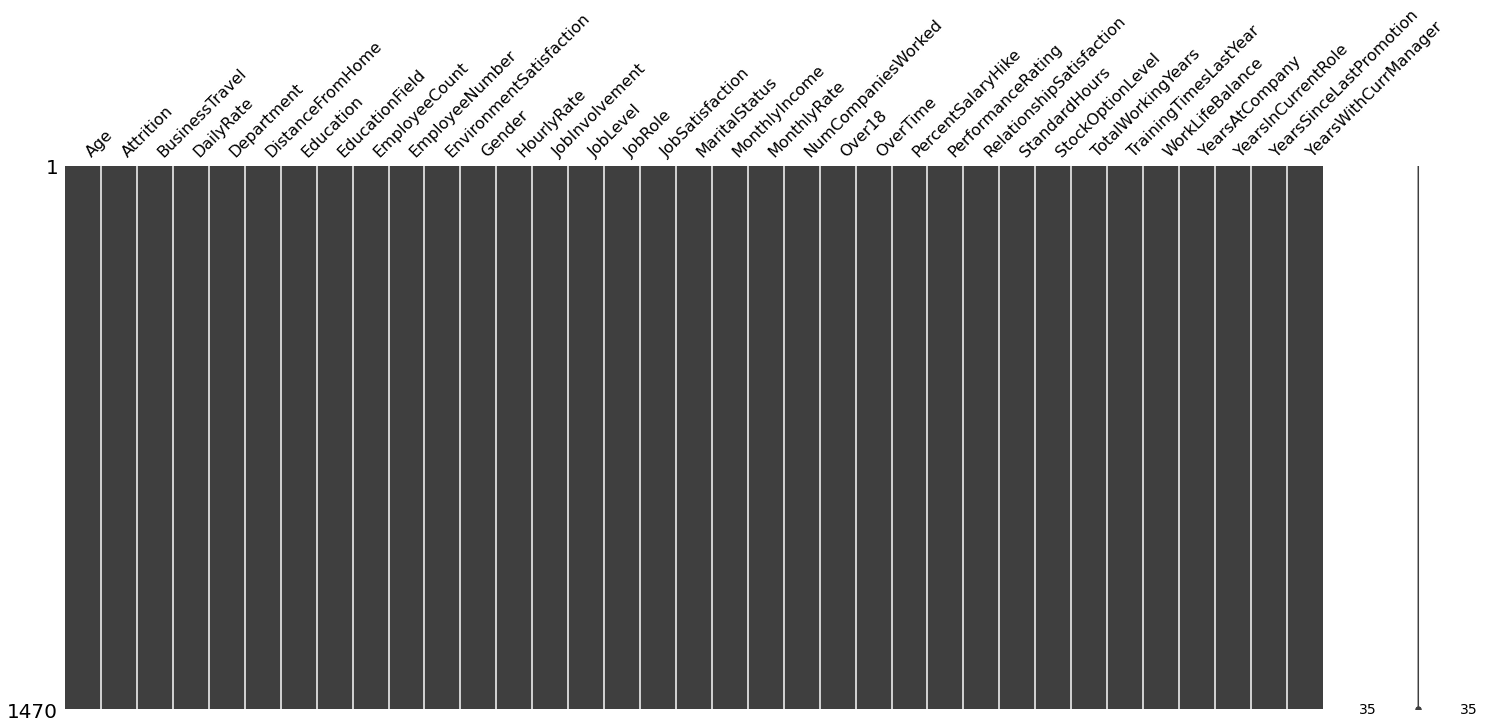

In [16]:
import missingno as ms
ms.matrix(df);

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Attrition'}>,
        <AxesSubplot:title={'center':'DailyRate'}>,
        <AxesSubplot:title={'center':'DistanceFromHome'}>,
        <AxesSubplot:title={'center':'Education'}>],
       [<AxesSubplot:title={'center':'EmployeeCount'}>,
        <AxesSubplot:title={'center':'EmployeeNumber'}>,
        <AxesSubplot:title={'center':'EnvironmentSatisfaction'}>,
        <AxesSubplot:title={'center':'HourlyRate'}>,
        <AxesSubplot:title={'center':'JobInvolvement'}>],
       [<AxesSubplot:title={'center':'JobLevel'}>,
        <AxesSubplot:title={'center':'JobSatisfaction'}>,
        <AxesSubplot:title={'center':'MonthlyIncome'}>,
        <AxesSubplot:title={'center':'MonthlyRate'}>,
        <AxesSubplot:title={'center':'NumCompaniesWorked'}>],
       [<AxesSubplot:title={'center':'OverTime'}>,
        <AxesSubplot:title={'center':'PercentSalaryHike'}>,
        <AxesSubplot:title={'center':'PerformanceRating'

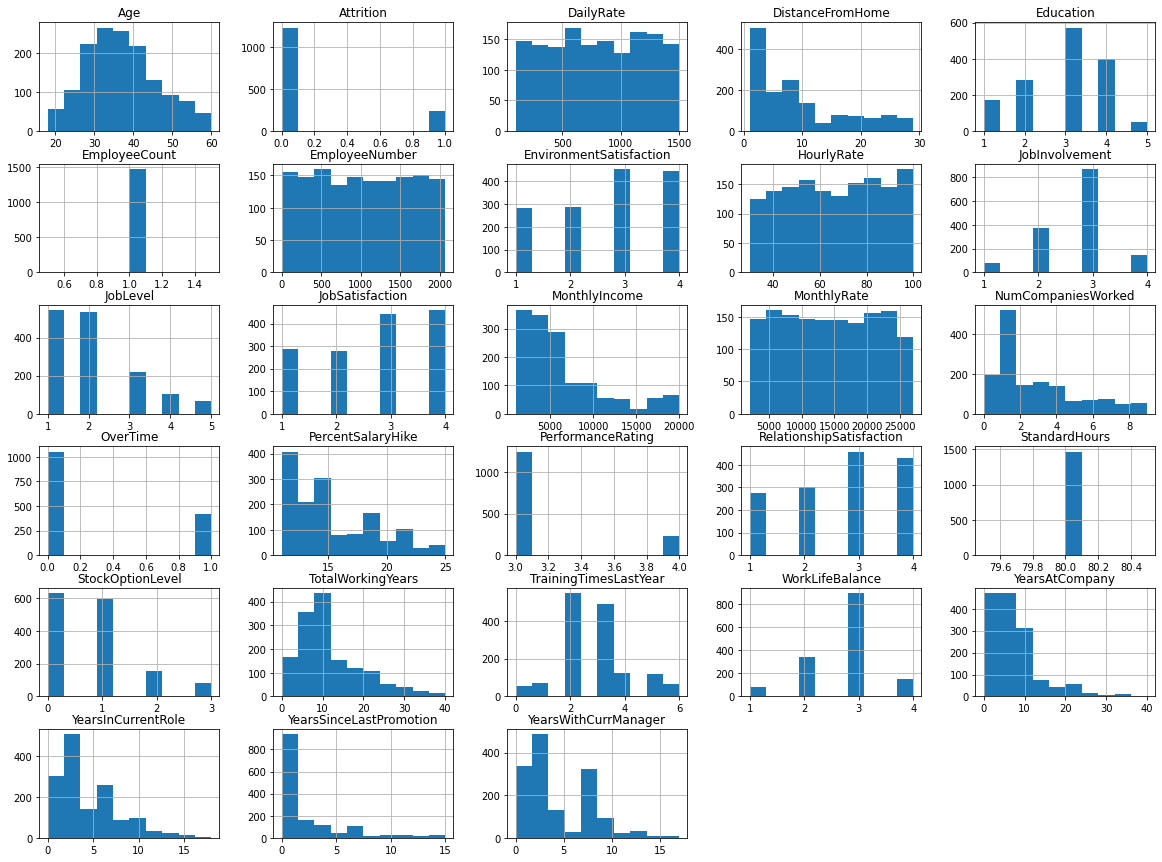

In [17]:
df.hist(figsize=(20, 15))

In [18]:
df_test.columns

Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_

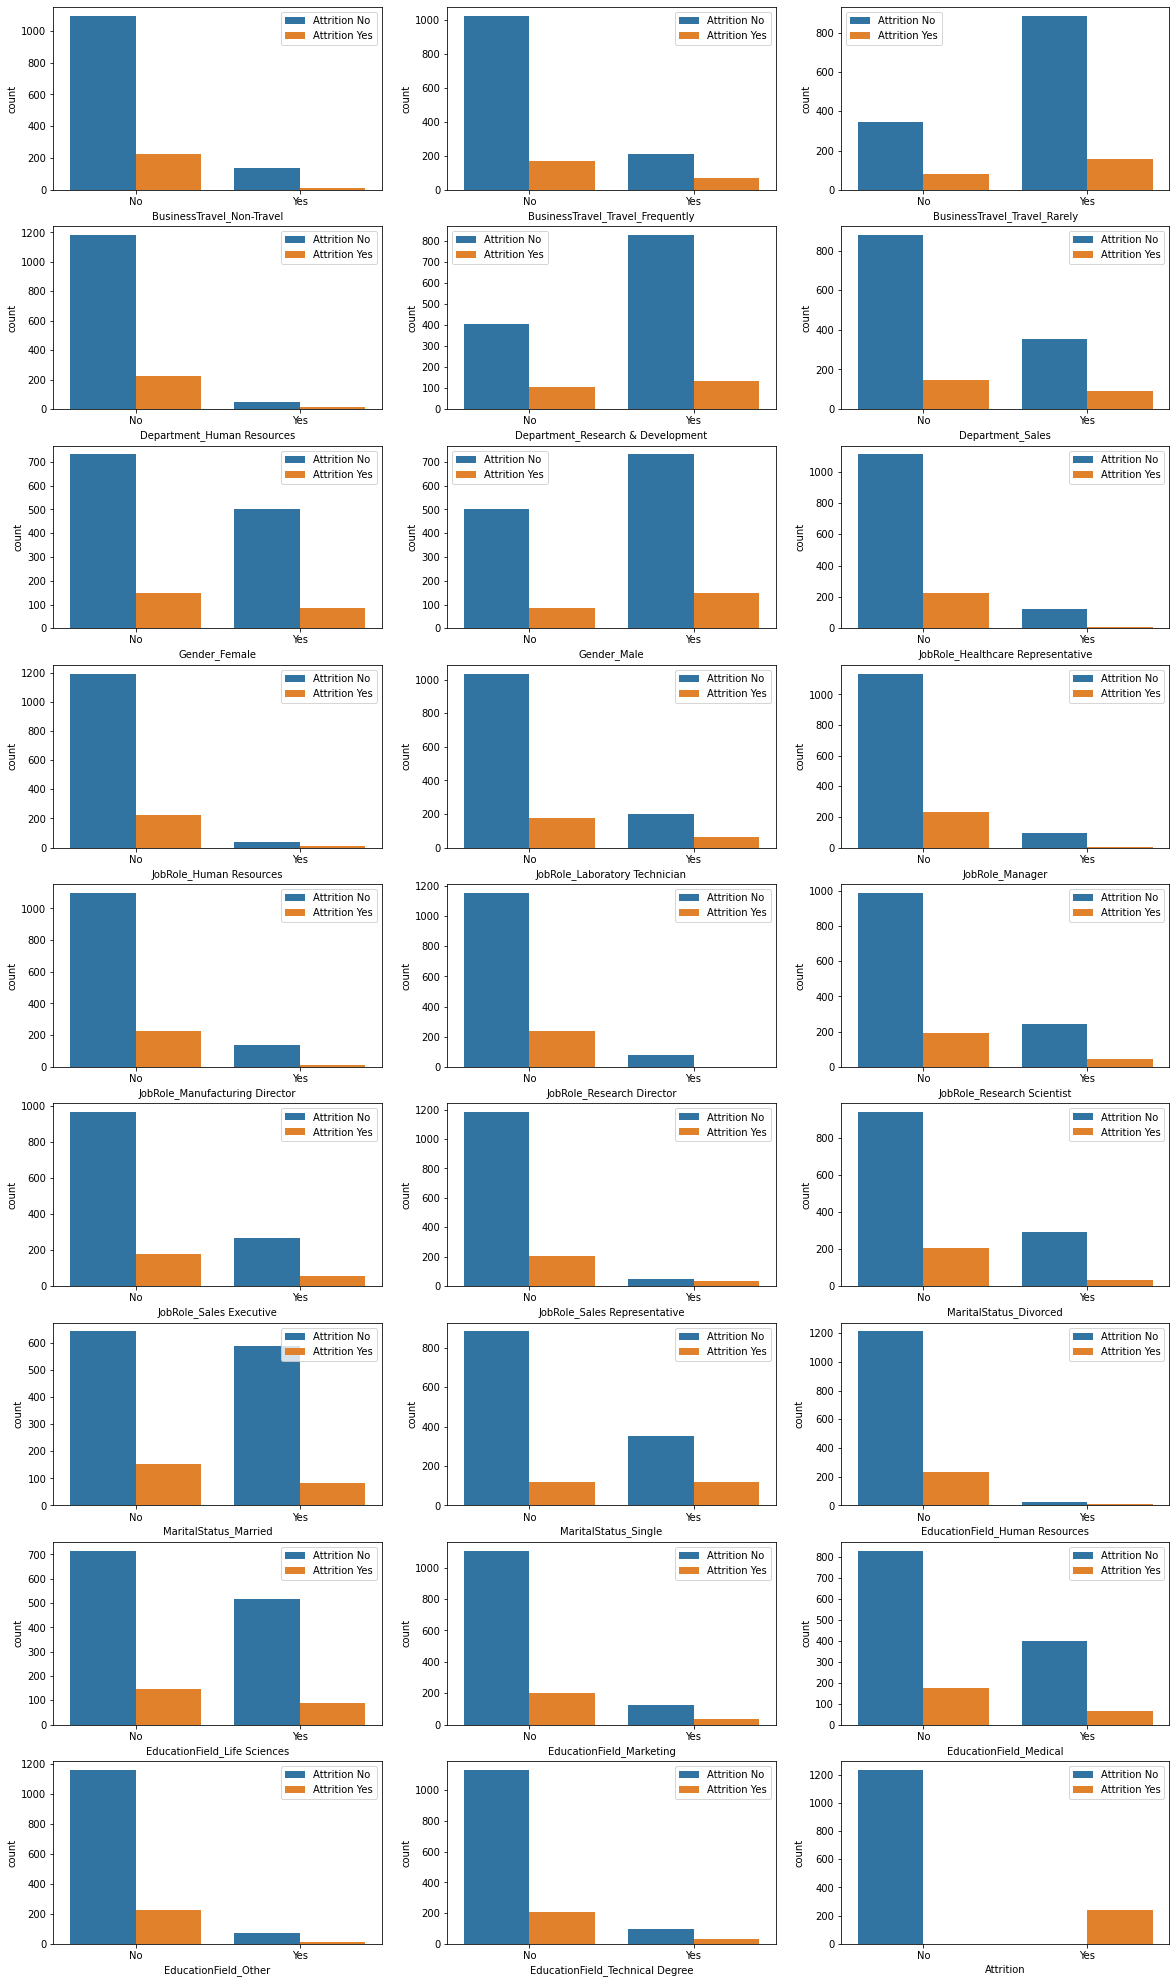

In [19]:
# Plot split bar charts for dummy categorical variables by Churn
df_cat = df_test[['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single','EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree', 'Attrition']]
count=1
plt.subplots(figsize=(20, 80))
for i in df_cat.columns:
    plt.subplot(20,3,count)
    ax = sns.countplot(x=i, hue='Attrition', data = df_cat)
    legend_labels, _= ax.get_legend_handles_labels()
    ax.legend(legend_labels, ['Attrition No','Attrition Yes'])
    ax.set_xticklabels(('No', 'Yes'))
    count+=1
plt.show();

# Intial Model

In [20]:
Xinit = df_test.drop('Attrition', axis = 1)
y = df_test['Attrition'].values

In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   Attrition                          1470 non-null   int64
 2   DailyRate                          1470 non-null   int64
 3   DistanceFromHome                   1470 non-null   int64
 4   Education                          1470 non-null   int64
 5   EmployeeCount                      1470 non-null   int64
 6   EmployeeNumber                     1470 non-null   int64
 7   EnvironmentSatisfaction            1470 non-null   int64
 8   HourlyRate                         1470 non-null   int64
 9   JobInvolvement                     1470 non-null   int64
 10  JobLevel                           1470 non-null   int64
 11  JobSatisfaction                    1470 non-null   int64
 12  MonthlyIncome       

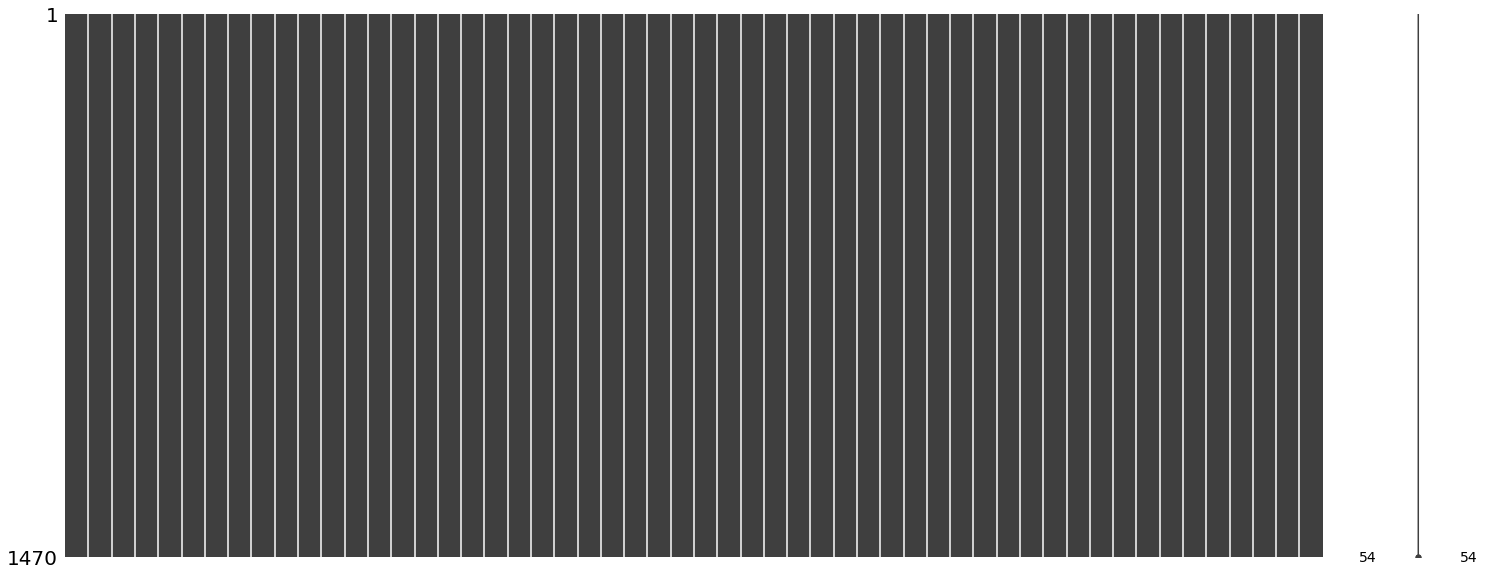

In [22]:
# Importing the libraries
import missingno as msno

# Visualize missing values as a matrix
msno.matrix(df_test);


In [23]:
df2 = df_test.select_dtypes(include=['uint8'])
df2.columns

Index(['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree'],
      dtype='object')

In [24]:
print ("There are", Xinit.shape[1], "independent variables in the initial model.")

There are 53 independent variables in the initial model.


<AxesSubplot:>

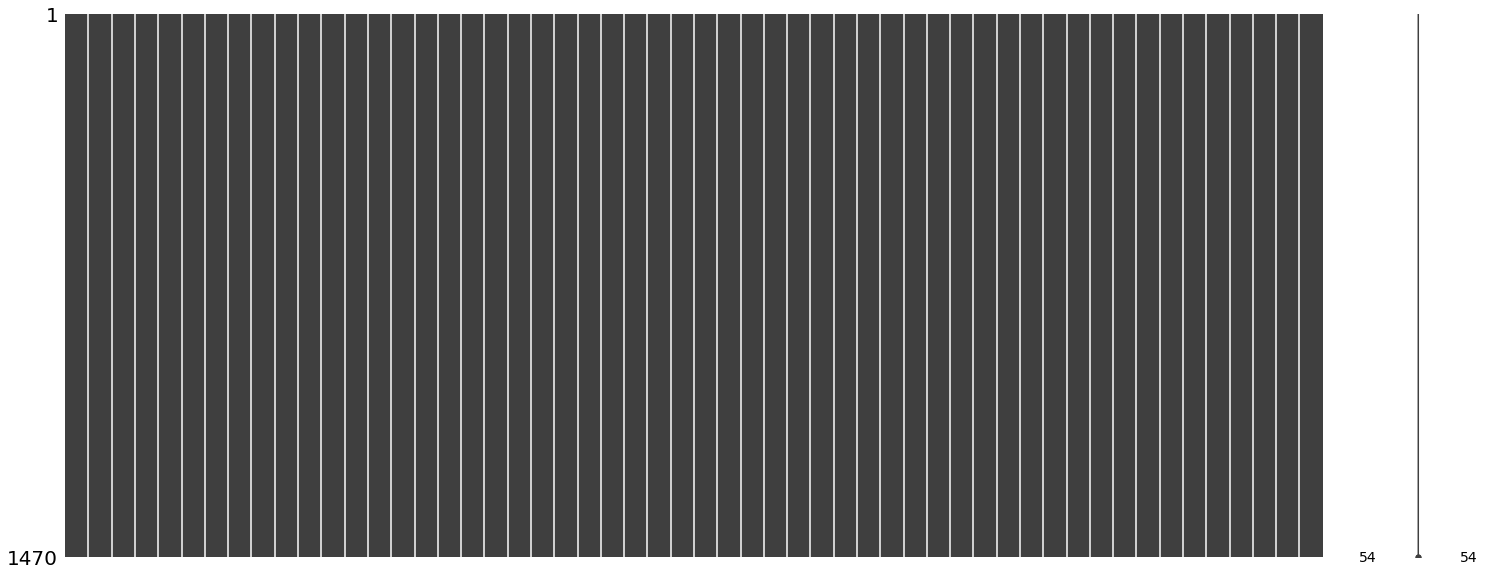

In [25]:
msno.matrix(df_test)

In [26]:
from sklearn.preprocessing import StandardScaler
Xcinit = sm.add_constant(Xinit)
logistic_regression = sm.Logit(y,Xcinit)
fitted_model1 = logistic_regression.fit()
fitted_model1.summary()

         Current function value: 0.291829
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1424
Method:                           MLE   Df Model:                           45
Date:                Tue, 12 Oct 2021   Pseudo R-squ.:                  0.3393
Time:                        15:52:10   Log-Likelihood:                -428.99
converged:                      False   LL-Null:                       -649.29
Covariance Type:            nonrobust   LLR p-value:                 2.321e-66
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Age                                  -0.0315      0.014     -2.320      0.020      -0.058      -0.005
DailyRate                            -0.0003      0.000     -1.290      0.197      -0.001       0.000
DistanceFromHome                      0.0459      0.011      4.250      0.000       0.025       0.067
Education                             0.0115      0.088      0.130      0.896      -0.161       0.184
EmployeeCount                         0.0001        nan        nan        nan         nan         nan
EmployeeNumber                       -0.0002      0.000     -1.015      0.310      -0.000       0.000
EnvironmentSatisfaction              -0.4341      0.083     -5.229      0.000      -0.597      -0.271
HourlyRate                            0.0012      0.004      0.262      0.793      -0.007       0.010
JobInvolvement                       -0.5269      0.123     -4.294      0.000      -0.767      -0.286
JobLevel                             -0.0938      0.316     -0.296      0.767      -0.714       0.526
JobSatisfaction                      -0.4143      0.082     -5.082      0.000      -0.574      -0.255
MonthlyIncome                      1.347e-05   8.15e-05      0.165      0.869      -0.000       0.000
MonthlyRate                        5.612e-06   1.25e-05      0.448      0.654    -1.9e-05    3.02e-05
NumCompaniesWorked                    0.1945      0.039      5.008      0.000       0.118       0.271
OverTime                              1.9789      0.194     10.209      0.000       1.599       2.359
PercentSalaryHike                    -0.0233      0.039     -0.592      0.554      -0.100       0.054
PerformanceRating                     0.1165      0.399      0.292      0.770      -0.666       0.899
RelationshipSatisfaction             -0.2654      0.083     -3.201      0.001      -0.428      -0.103
StandardHours                         0.0092        nan        nan        nan         nan         nan
StockOptionLevel                     -0.1930      0.159     -1.216      0.224      -0.504       0.118
TotalWorkingYears                    -0.0599      0.029     -2.042      0.041      -0.117      -0.002
TrainingTimesLastYear                -0.1884      0.073     -2.576      0.010      -0.332      -0.045
WorkLifeBalance                      -0.3725      0.124     -2.999      0.003      -0.616      -0.129
YearsAtCompany                        0.0961      0.039      2.470      0.014       0.020       0.172
YearsInCurrentRole                   -0.1513      0.046     -3.323      0.001      -0.241      -0.062
YearsSinceLastPromotion               0.1735      0.042      4.090      0.000       0.090       0.257
YearsWithCurrManager                 -0.1367      0.047     -2.907      0.004      -0.229      -0.045
BusinessTravel_Non-Travel            -0.9787        nan        nan        nan         nan         nan
BusinessTravel_Travel_Frequently      0.9305        nan        nan        nan  

In [27]:
clf = LogisticRegression()
clf.fit(Xinit, y.astype(int))
y_clf = clf.predict(Xinit)
print(classification_report(y, y_clf))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1233
           1       0.67      0.01      0.02       237

    accuracy                           0.84      1470
   macro avg       0.75      0.50      0.46      1470
weighted avg       0.81      0.84      0.77      1470



In [28]:
# Use recursive feature elimination to choose most important features (ref 6)
model = LogisticRegression()
rfe = RFE(model, 10) 
rfe = rfe.fit(Xcinit, y)
print(rfe.support_)
print('\n')
print(rfe.ranking_)
f = rfe.get_support(1) # the most important features
Xfin = Xinit[Xinit.columns[f]] # final features`

[False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False  True False False False False False False False  True
 False  True False  True  True False False  True False False  True  True
 False False False False  True]


[33 39 32 37 38 43  6 42  3 24  7 40 44 18  1 35 34 14 30 13 21 15  8 25
 16 17 22  1  2 31 12 20 11 19  9  1  4  1 41  1  1 29 36  1 28 10  1  1
 27  5 23 26  1]


In [29]:
# Look for evidence of Variance Inflation Factors (ref 7) causing multicollinearity
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = Xfin.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(Xfin.values, i) 
                          for i in range(len(Xfin.columns))] 
  
print(vif_data)

                             feature       VIF
0                           OverTime  1.190818
1          BusinessTravel_Non-Travel  1.068236
2  JobRole_Healthcare Representative  1.059149
3      JobRole_Laboratory Technician  1.114727
4     JobRole_Manufacturing Director  1.059901
5          JobRole_Research Director  1.027454
6       JobRole_Sales Representative  1.064237
7               MaritalStatus_Single  1.251665
8     EducationField_Human Resources  1.010059
9    EducationField_Technical Degree  1.070315


In [30]:
# Re-run the model
Xcfin = sm.add_constant(Xfin)
logistic_regression = sm.Logit(y,Xcfin)
fitted_model2 = logistic_regression.fit()
fitted_model2.summary()

Optimization terminated successfully.
         Current function value: 0.366751
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1459
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Oct 2021   Pseudo R-squ.:                  0.1697
Time:                        15:52:12   Log-Likelihood:                -539.12
converged:                       True   LL-Null:                       -649.29
Covariance Type:            nonrobust   LLR p-value:                 9.096e-42
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -2.7309      0.163    -16.711      0.000      -3.051      -2.411
OverTime                              1.5046      0.160      9.409      0.000       1.191       1.818
BusinessTravel_Non-Travel            -0.8514      0.326     -2.609      0.009      -1.491      -0.212
JobRole_Healthcare Representative    -0.8453      0.371     -2.276      0.023      -1.573      -0.117
JobRole_Laboratory Technician         0.7442      0.192      3.871      0.000       0.367       1.121
JobRole_Manufacturing Director       -0.9033      0.356     -2.539      0.011      -1.601      -0.206
JobRole_Research Director            -1.9307      0.733     -2.636      0.008      -3.367      -0.495
JobRole_Sales Representative          1.2973      0.274      4.737      0.000       0.761       1.834
MaritalStatus_Single                  1.0088      0.159      6.351      0.000       0.697       1.320
EducationField_Human Resources        1.1391      0.486      2.345      0.019       0.187       2.091
EducationField_Technical Degree       0.6633      0.245      2.706      0.007       0.183       1.144
=====================================================================================================
"""

In [31]:
X_train, X_test, y_train, y_test = train_test_split(Xfin, y.astype(float), test_size=0.33, random_state=101)

In [32]:
Xcfin = sm.add_constant(X_train)
logistic_regression = sm.Logit(y_train,Xcfin)
fitted_model2 = logistic_regression.fit()
fitted_model2.summary()

Optimization terminated successfully.
         Current function value: 0.356205
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  984
Model:                          Logit   Df Residuals:                      973
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Oct 2021   Pseudo R-squ.:                  0.1916
Time:                        15:52:12   Log-Likelihood:                -350.51
converged:                       True   LL-Null:                       -433.56
Covariance Type:            nonrobust   LLR p-value:                 1.767e-30
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -2.9928      0.210    -14.240      0.000      -3.405      -2.581
OverTime                              1.5936      0.201      7.939      0.000       1.200       1.987
BusinessTravel_Non-Travel            -0.6501      0.376     -1.730      0.084      -1.387       0.086
JobRole_Healthcare Representative    -0.7516      0.463     -1.624      0.104      -1.659       0.156
JobRole_Laboratory Technician         0.9689      0.238      4.070      0.000       0.502       1.436
JobRole_Manufacturing Director       -0.6991      0.430     -1.624      0.104      -1.543       0.145
JobRole_Research Director            -2.0914      1.031     -2.029      0.042      -4.111      -0.071
JobRole_Sales Representative          1.3069      0.340      3.846      0.000       0.641       1.973
MaritalStatus_Single                  1.3353      0.197      6.762      0.000       0.948       1.722
EducationField_Human Resources        0.9866      0.622      1.585      0.113      -0.233       2.207
EducationField_Technical Degree       0.6254      0.290      2.156      0.031       0.057       1.194
=====================================================================================================
"""

In [33]:
# verification
clf = LogisticRegression()
clf.fit(X_train, y_train.astype(int))
y_clf = clf.predict(X_test)
print(classification_report(y_test, y_clf))

              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       407
         1.0       0.65      0.14      0.23        79

    accuracy                           0.85       486
   macro avg       0.75      0.56      0.57       486
weighted avg       0.82      0.85      0.80       486



In [34]:
# View prediction (initial)
clf = LogisticRegression()
clf.fit(Xinit, y.astype(int))
y_clf = clf.predict(Xinit)
print(classification_report(y, y_clf))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1233
           1       0.67      0.01      0.02       237

    accuracy                           0.84      1470
   macro avg       0.75      0.50      0.46      1470
weighted avg       0.81      0.84      0.77      1470



In [35]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import accuracy_score

import mlflow
import mlflow.sklearn

client = mlflow.tracking.MlflowClient()

try: 
    experiment = client.create_experiment(name = "HR_Logistic Regression")
except:
    print('Experiment Already Exists. Please check folder.')


Experiment Already Exists. Please check folder.


In [36]:
with mlflow.start_run(experiment_id='5', run_name='HR_Logistic Regression') as run:
    # Get the run and experiment id 
    run_id = run.info.run_uuid
    experiment_id = run.info.experiment_id
    
    #train, test = train_test_split(data)
    X_train, X_test, y_train, y_test = train_test_split(Xfin, y.astype(float), test_size=0.33, random_state=101)
    
    #Logistic Regression 
    lr = LogisticRegression()
    lr.fit(X_test, y_test)
    
    
    
#Metrics 
    #Precision
    precision = 22

    #Recall 
    recall = 22

    #Accuracy
    acc = 22
    #acc = accuracy_score(y_true, y_pred)    #accuracy
    score = lr.score(X_test, y_test)        #score 
    
    #Confusion Matrix, save confusion matrix to ML runs 
    clf = LogisticRegression()
    clf.fit(X_train, y_train.astype(int))           # logistic Regression Fit
    y_clf = clf.predict(X_test)                    # adad 
    print(classification_report(y_test, y_clf))    # sdsd
        
    #log Metrics 
        #mlflow.log_metric('Name', output) 
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("score", score)
   
    
     #Log Model
    mlflow.sklearn.log_model(lr, "model")
    
    
    #Print Metrics 
    print()
    print("Precision: %s" % precision)
    print("Recall: %s" % recall)
    print("Accuracy: %s" % acc)
    print("Score: %s" % score)
    print("Model saved in run %s" % mlflow.active_run().info.run_uuid)
    

              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       407
         1.0       0.65      0.14      0.23        79

    accuracy                           0.85       486
   macro avg       0.75      0.56      0.57       486
weighted avg       0.82      0.85      0.80       486


Precision: 22
Recall: 22
Accuracy: 22
Score: 0.845679012345679
Model saved in run 9df6d7d47485498ebcbc470e3d67fa16


In [37]:
classification_report

<function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>